In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os
sys.path.append(os.path.expanduser('~/PYTHON/ATP/'))
import ceo
import yaml
import pandas as pd
import numpy as np
import atp
import matplotlib.pyplot as plt

from astropy.units import Quantity
from astropy.time import Time
import astropy.io.fits as pyfits

def gmtstatetomodes(gmt):
    state = gmt.state
    modes = np.zeros(82)

    M1Txyz = np.reshape(state['M1']['Txyz'],21)
    modes[[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62,72,73,74]] = M1Txyz

    M2Txyz = np.reshape(state['M2']['Txyz'],21)
    modes[[6,7,8,18,19,20,30,31,32,42,43,44,54,55,56,66,67,68,77,78,79]] = M2Txyz

    M1Rxyz = np.reshape(state['M1']['Rxyz'],21)
    modes[[3,4,5,15,16,17,27,28,29,39,40,41,51,52,53,63,64,65,75,76]] = M1Rxyz[0:20]

    M2Rxyz = np.reshape(state['M2']['Rxyz'],21)
    modes[[9,10,11,21,22,23,33,34,35,45,46,47,57,58,59,69,70,71,80,81]] = M2Rxyz[0:20]

    return modes

def modestogmtstate(gmt,modes):
    state = gmt.state

    M1Txyz = modes[[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62,72,73,74]]
    state['M1']['Txyz'] = np.reshape(M1Txyz,(7,3))

    M2Txyz = modes[[6,7,8,18,19,20,30,31,32,42,43,44,54,55,56,66,67,68,77,78,79]]
    state['M2']['Txyz'] = np.reshape(M2Txyz,(7,3))

    M1Rxyz = np.zeros(21)
    M1Rxyz[0:20] = modes[[3,4,5,15,16,17,27,28,29,39,40,41,51,52,53,63,64,65,75,76]]
    state['M1']['Rxyz'] = np.reshape(M1Rxyz,(7,3))

    M2Rxyz = np.zeros(21)
    M2Rxyz[0:20] = modes[[9,10,11,21,22,23,33,34,35,45,46,47,57,58,59,69,70,71,80,81]]
    state['M2']['Rxyz'] = np.reshape(M2Rxyz,(7,3))
    gmt^=state

/home/ubuntu/CEO/python/ceo/zemax


In [2]:

L=25.5
nLenslet = 24
threshold = 0.5 # subaperture flux threshold

girmode = "tracking"
config = "dgwf"
saveresults = 0

# load the data about the observation
data = pyfits.getdata(os.path.expanduser('~/PYTHON/AGWS/SAO/weather_pointing_data.fits'))
temperature = data[:,0] # Temperature draw in deg C
pressure = data[:,1] # Pressure draw in mbar
humidity = data[:,2] # Relative humidity in %
windspeed = data[:,3] # Wind speed in m/s
winddir = data[:,4] # Wind direction in degrees
datetime = data[:,5] # Date vector (Clay is first 500, Baade is second 500)
scira = data[:,6] # RA vector (degrees; Clay is first 500, Baade is second 500)
scidec = data[:,7] #  Declination vector (degrees; Clay is first 500, Baade is second 500)
telaz = data[:,8] # Azimuth angle of telescope (degrees; Clay is first 500, Baade is second 500)
telel = data[:,9] # Elevation angle of telescope (degrees; Clay is first 500, Baade is second 500)
r0 = data[:,10] # r0 (cm)
L0 = data[:,11] # L0 (m)

gmt = ceo.GMT_MX()

In [3]:

pupil_size = 25.5
N_SIDE_LENSLET = 24 # The linear size of the lenslet array (>=1).
N_PX_LENSLET = 24 # The sampling in pixel of one lenslet.
d = pupil_size/N_SIDE_LENSLET # The lenslet pitch [m].
DFT_osf = 2 # [2] optional The oversampling factor for the DFT
N_PX_IMAGE = N_PX_LENSLET*DFT_osf # int, optional The sampling in pixel of the imagelet [N_PX_LENSLET]
BIN_IMAGE = 6 # optional The binning factor of the imagelet [1]
N_GS = 1 # optional The number of guide stars [1]
exposureTime = 0.005 
readOutNoiseRms = 0.56
noiseFactor = np.sqrt(2.)
sky_magnitude = 19.2

gs_wavelength = 715e-9
r0_wavelength = 500e-9

savefilename = config+'_tt7err.fits'

### TT7 measurement error = f(mag, seeing, airmass, throughput(opt config))

In [11]:
telzen = 0*np.pi/180. #at zenith
airmass = 1./np.cos(telzen)

zeropoint_correction = 16.9e9 / 24.46e9
atmospheric_throughput = 0.96**airmass 
if config == "dgwf":
    telescope_throughput = 0.589 
else:
    telescope_throughput = 0.724
agws_throughput = 0.75
dust_throughput = 0.90
quantum_efficiency = 0.65 # quantum efficiency    

photoElectronGain = zeropoint_correction*atmospheric_throughput*telescope_throughput*agws_throughput*dust_throughput*quantum_efficiency

r0_val = 0.16
r0_val *= atp.r0_scaling(r0_wavelength,gs_wavelength,telzen)
seeing_rad = gs_wavelength/r0_val
seeing_arcsec = seeing_rad*ceo.constants.RAD2ARCSEC
print("seeing (arcsec) : %5.3f" %seeing_arcsec)

seeing (arcsec) : 0.600


In [66]:
xpos = 0
ypos = 0
#vismag = np.arange(9,21.5,0.5)
vismag = np.arange(9,21.1,0.5)

In [64]:
vismag

array([ 9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. ,
       14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5,
       20. , 20.5, 21. ])

In [35]:
print(N_SIDE_LENSLET* N_PX_LENSLET, d, DFT_osf, N_PX_IMAGE, BIN_IMAGE)

576 1.0625 2 48 6


In [72]:
results = []
for mag in vismag:
    zen = np.hypot(xpos,ypos)/3600.*np.pi/180 # radial distance in radians
    azi = np.arctan2(ypos,xpos) # azimuth in radians

    wfs_prms = {'N_SIDE_LENSLET':N_SIDE_LENSLET,
                'N_PX_LENSLET':N_PX_LENSLET,'d':d,
                'DFT_osf':DFT_osf,'N_PX_IMAGE':N_PX_IMAGE,'BIN_IMAGE':BIN_IMAGE,'N_GS': N_GS,
                'readOutNoiseRms':readOutNoiseRms,'noiseFactor':noiseFactor,
                'photoElectronGain':photoElectronGain, 'exposureTime':exposureTime,'intensityThreshold':0.0}
    wfs = ceo.ShackHartmann(**wfs_prms)
    gs = ceo.Source(photometric_band="R+I",zenith=zen,azimuth=azi,magnitude=mag,
                    rays_box_size=pupil_size,rays_box_sampling=N_SIDE_LENSLET*N_PX_LENSLET+1,rays_origin=[0,0,25])
    ~gmt

    # segment tip-tilt interaction matrix (use M2)
    gs.reset()
    gmt.reset()
    gmt.propagate(gs)
    wfs.calibrate(gs,threshold)
    gs>>(gmt,wfs)

    wfs.camera.nBackgroundPhoton = gs.nBackgroundPhoton(sky_magnitude)*11.42 # fudge factor of 11.42 to get the right values (see tt7photometry)

    simatm = 0 # simulate atmosphere or simply use
    if simatm == 0:
        # make the source larger to emulate atmospheric turbulence
        fwhm_arcsec = np.sqrt(0.25**2+seeing_arcsec**2)
    else:
        fwhm_arcsec = 0.25
    

    unbinned_pixel_scale_arcsec = wfs.pixel_scale_arcsec/BIN_IMAGE
    gs.fwhm = fwhm_arcsec/unbinned_pixel_scale_arcsec

    nmes = len(wfs.get_measurement())
    poke = 5e-6
    nmodes = 82
    H = np.zeros((nmes,nmodes))

    ~gmt
    for k in range(nmodes):
        modes = np.zeros(nmodes)
        modes[k] = poke
        modestogmtstate(gmt,modes)
        ~wfs
        gs>>(gmt,wfs)
        +gs
        +wfs
        mes1 = wfs.get_measurement()
        H[:,k] = mes1/poke

    # since we are going to compensate with M2 segment tip-tilt, we want to reconstruct M2 Rxy only!
    M2Rxy = [9,10,21,22,33,34,45,46,57,58,69,70,80,81]
    H7 = H[:,M2Rxy]

    nmes7 = len(mes1)
    cMat7 = np.linalg.solve(np.transpose(H7)@H7,np.transpose(H7)) # H^-1 = (H^+ H)^-1 H^+

    # reconstruct global tip-tilt to find the magnitude of the M2 ASM tip-tilt modes
    nvl = np.sum(wfs.valid_lenslet.f.host(shape=(N_GS,N_SIDE_LENSLET**2))>0,axis=1)[0]
    
    cent = np.zeros(2*nvl)
    cent[0:nvl] = 1./206265.
    mx = cMat7@cent
    arcsec2mode = np.sqrt(np.sum(mx**2)/7.)
    mode2arcsec = 1./arcsec2mode

    # an M2Rxy mode leads to 0.2466 arcsec of geometric centroids
    # mode2arcsec = 0.2466

    # check for saturation
    ~wfs
    gs>>(gmt,wfs)
    +gs
    +wfs
    frame = np.array(wfs.camera.ghost_frame[:wfs.N_PX_FRAME,:])

    maxEM = 145e3/np.max(frame)
    EM = np.clip(maxEM,1,200)

    readOutNoiseRms = 0.1+100./EM
    wfs.camera.readOutNoiseRms = readOutNoiseRms

    # add turbulence, aberrations (FWHM=0.25, DAR)
    # look at TurbulenceSimulation.py to see how turbulence is added

    ~gmt    
    modeerr = np.zeros((14,100))
    centerr = np.zeros((2*nvl,100))
    for k1 in range(100):
        ~wfs
        gs>>(gmt,wfs)
        +gs
        +wfs
        mes = wfs.get_measurement()
        centerr[:,k1] = mes
        modeerr[:,k1] = cMat7@mes
        
    # calculate the standard deviation of each mode
    moderms = np.std(modeerr,axis=1)
    tt7rms_arcsec = np.sqrt(np.mean(moderms**2))*mode2arcsec
    print('mag =', mag, '   error along each axis (arcsec)',tt7rms_arcsec)
    results.append(tt7rms_arcsec)
results = np.array(results)

mag = 9.0    error along each axis (arcsec) 0.0008197665563791004
mag = 9.5    error along each axis (arcsec) 0.001113026053243372
mag = 10.0    error along each axis (arcsec) 0.001484697659610549
mag = 10.5    error along each axis (arcsec) 0.0021630886032956475
mag = 11.0    error along each axis (arcsec) 0.0028195993213320147
mag = 11.5    error along each axis (arcsec) 0.0036409169495158927
mag = 12.0    error along each axis (arcsec) 0.004331590296213031
mag = 12.5    error along each axis (arcsec) 0.004805409863567292
mag = 13.0    error along each axis (arcsec) 0.005100417881006767
mag = 13.5    error along each axis (arcsec) 0.00565561494539595
mag = 14.0    error along each axis (arcsec) 0.00569561031218772
mag = 14.5    error along each axis (arcsec) 0.00524086356836326
mag = 15.0    error along each axis (arcsec) 0.00559091077435274
mag = 15.5    error along each axis (arcsec) 0.005874752276156511
mag = 16.0    error along each axis (arcsec) 0.006381467473849945
mag = 16.5  

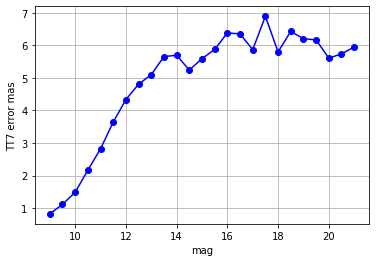

In [76]:
plt.plot(vismag, results*1000,'-bo')
plt.ylabel('TT7 error mas')
plt.xlabel('mag')
plt.grid();

In [77]:
1./np.pi*180*3600

206264.80624709636